## Task 1.1: Web Scraping - Setup and Imports

In this step, we import the necessary libraries for web scraping and data manipulation.
* `requests`: To send HTTP requests to the website.
* `BeautifulSoup` (bs4): To parse the HTML content and extract specific elements.
* `pandas`: To store the scraped data in a structured DataFrame and save it as a CSV.
* `re`: Regular expressions for extracting numbers (like stock count) from text.
* `time`: To add a delay between requests to avoid overwhelming the server.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time

# Base URL for the website
BASE_URL = "https://books.toscrape.com/"

print("Libraries imported successfully.")

Libraries imported successfully.


### Helper Function: Scrape Single Book Details

We need to extract specific fields: Title, Price, Availability, Rating, Description, Category, and UPC.
Since the `star_rating` is stored as a CSS class (e.g., "star-rating Three"), we use a dictionary to map words to integers.

In [5]:
def scrape_book_details(book_url):
    """
    Fetches and parses details for a single book from its specific URL.
    Includes robust price extraction to handle encoding errors.
    """
    try:
        response = requests.get(book_url)
        if response.status_code != 200:
            return None
        
        # Force encoding to UTF-8 to minimize symbol issues
        response.encoding = 'utf-8' 
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # 1. Title
        title = soup.find('h1').text.strip()
        
        # 2. Price (ROBUST FIX: Extract numbers only)
        price_text = soup.find('p', class_='price_color').text
        # Look for a pattern like 12.34
        price_match = re.search(r"\d+\.\d+", price_text)
        if price_match:
            price = float(price_match.group())
        else:
            price = 0.0
        
        # 3. Availability (Extract number)
        availability_text = soup.find('p', class_='instock availability').text.strip()
        stock_count = int(re.findall(r'\d+', availability_text)[0])
        
        # 4. Star Rating
        star_mapping = {'One': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5}
        star_class = soup.find('p', class_='star-rating')['class'][1]
        star_rating = star_mapping.get(star_class, 0)
        
        # 5. Description
        desc_header = soup.find('div', id='product_description')
        if desc_header:
            product_description = desc_header.find_next_sibling('p').text.strip()
        else:
            product_description = "No description available"
            
        # 6. Category
        breadcrumb = soup.find('ul', class_='breadcrumb')
        category = breadcrumb.find_all('li')[2].text.strip()
        
        # 7. Product Code (UPC)
        upc = soup.find('th', text='UPC').find_next_sibling('td').text
        
        return {
            'title': title,
            'price': price,
            'availability': stock_count,
            'star_rating': star_rating,
            'product_description': product_description,
            'category': category,
            'product_code': upc
        }

    except Exception as e:
        print(f"Error scraping {book_url}: {e}")
        return None
        
print("Helper function updated with robust price fixing.")

Helper function updated with robust price fixing.


In [6]:
# Test URL with the robust function
test_url = "https://books.toscrape.com/catalogue/a-light-in-the-attic_1000/index.html"

print("Testing robust scraper...")
result = scrape_book_details(test_url)

if result:
    print("SUCCESS! Data:")
    print(f"Title: {result['title']}")
    print(f"Price: {result['price']}") # Should be a clean float (e.g. 51.77)
else:
    print("Failed.")

Testing robust scraper...
SUCCESS! Data:
Title: A Light in the Attic
Price: 51.77


C:\Users\User\AppData\Local\Temp\ipykernel_6680\4284461131.py:48: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  upc = soup.find('th', text='UPC').find_next_sibling('td').text


### Main Execution Loop

We will iterate through the catalogue pages (e.g., `page-1.html`, `page-2.html`).
On each catalogue page, we find all book links, visit them using our helper function, and store the data.
The loop stops once we have collected at least 200 books.

In [7]:
books_data = []
page_number = 1
target_book_count = 200

print(f"Starting scrape. Target: {target_book_count} books...")

while len(books_data) < target_book_count:
    # Construct the URL for the catalogue page
    catalogue_url = f"{BASE_URL}catalogue/page-{page_number}.html"
    
    response = requests.get(catalogue_url)
    
    # Break if we run out of pages
    if response.status_code != 200:
        print(f"Failed to retrieve catalogue page {page_number}. Stopping.")
        break
        
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find all book articles on this page
    articles = soup.find_all('article', class_='product_pod')
    
    for article in articles:
        # Get the relative link to the book detail page
        relative_url = article.find('h3').find('a')['href']
        
        # Handle URL formatting (sometimes links have ../ in them)
        if "catalogue/" in relative_url:
            book_url = BASE_URL + relative_url
        else:
            book_url = BASE_URL + "catalogue/" + relative_url
            
        # Scrape the individual book
        book_details = scrape_book_details(book_url)
        
        if book_details:
            books_data.append(book_details)
            
            # periodic status update
            if len(books_data) % 50 == 0:
                print(f"Collected {len(books_data)} books so far...")
        
        # Stop exactly when we hit the target (optional, can also finish the page)
        if len(books_data) >= target_book_count:
            break
            
    print(f"Finished processing Page {page_number}")
    page_number += 1
    
    # Be polite to the server
    time.sleep(1)

print(f"Scraping complete. Total books collected: {len(books_data)}")

Starting scrape. Target: 200 books...


C:\Users\User\AppData\Local\Temp\ipykernel_6680\4284461131.py:48: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  upc = soup.find('th', text='UPC').find_next_sibling('td').text


Finished processing Page 1
Finished processing Page 2
Collected 50 books so far...
Finished processing Page 3
Finished processing Page 4
Collected 100 books so far...
Finished processing Page 5
Finished processing Page 6
Finished processing Page 7
Collected 150 books so far...
Finished processing Page 8
Finished processing Page 9
Collected 200 books so far...
Finished processing Page 10
Scraping complete. Total books collected: 200


### Step 4: Save Data to CSV

We convert the list of dictionaries into a Pandas DataFrame.
Then, we save it as `scraped_books.csv` so we can use it in the next task.

In [8]:
# Create a DataFrame from the collected list
df = pd.DataFrame(books_data)

# Display the first few rows to make sure it looks good
print(f"DataFrame Shape: {df.shape}")
display(df.head())

# Save to a CSV file
csv_filename = 'scraped_books.csv'
df.to_csv(csv_filename, index=False)

print(f"\nSUCCESS: Data saved to '{csv_filename}'.")
print("Task 1.1 is now complete.")

DataFrame Shape: (200, 7)


,title,price,availability,star_rating,product_description,category,product_code
0,A Light in the Attic,51.77,22,3,It's hard to imagine a world without A Light i...,Poetry,a897fe39b1053632
1,Tipping the Velvet,53.74,20,1,"""Erotic and absorbing...Written with starling ...",Historical Fiction,90fa61229261140a
2,Soumission,50.10,20,1,"Dans une France assez proche de la nôtre, un h...",Fiction,6957f44c3847a760
3,Sharp Objects,47.82,20,4,"WICKED above her hipbone, GIRL across her hear...",Mystery,e00eb4fd7b871a48
4,Sapiens: A Brief History of Humankind,54.23,20,5,From a renowned historian comes a groundbreaki...,History,4165285e1663650f



SUCCESS: Data saved to 'scraped_books.csv'.
Task 1.1 is now complete.


## Task 1.2: Dataset Integration

In this step, we load the external **Goodreads** dataset.
We will inspect columns to find commonalities with our **Scraped** dataset (e.g., Title, Rating).

In [1]:
import pandas as pd
import os

# Check if file exists before trying to load
goodreads_file = 'goodreads_books.csv'

if not os.path.exists(goodreads_file):
    print(f"ERROR: Could not find '{goodreads_file}'.")
    print("Please download it from Kaggle, unzip it, move it to this folder, and rename it to 'goodreads_books.csv'.")
else:
    # Load the data with 'on_bad_lines' to skip formatting errors
    # AND 'encoding="latin1"' to fix the byte error
    try:
        df_goodreads = pd.read_csv(goodreads_file, on_bad_lines='skip', encoding='latin1')
        print("Goodreads Data Loaded Successfully.")
        print(f"Shape: {df_goodreads.shape}")
        display(df_goodreads.head(3))
    except Exception as e:
        print(f"Still having trouble? Error details: {e}")

Goodreads Data Loaded Successfully.
Shape: (11127, 13)


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,Unnamed: 12
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,NaN
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,NaN
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,NaN


### Clean and Align Columns

To combine the datasets logically, we need matching column names.
1. **Rename** `average_rating` to `star_rating`.
2. **Rename** `title` to `title` (ensure lowercase consistency).
3. **Add a `source` column** to indicate where the data came from (e.g., 'Web Scrape' vs 'Kaggle').
4. **Select only relevant columns** to keep the final dataset clean.

In [2]:
# 1. Load the Scraped Data (if not already loaded)
df_scraped = pd.read_csv('scraped_books.csv')

# 2. Add 'source' columns
df_scraped['source'] = 'Scraped_Fictional'
df_goodreads['source'] = 'Goodreads_Real'

# 3. Rename Goodreads columns to match our Scraped data
# Note: Goodreads text columns often have extra spaces, so we strip them first
df_goodreads.columns = df_goodreads.columns.str.strip()

df_goodreads.rename(columns={
    'average_rating': 'star_rating',
    '  num_pages': 'num_pages' # Common issue in this dataset: spaces in column names
}, inplace=True)

# 4. Handle Missing Columns
# The scraped data has 'price', but Goodreads does not. 
# We will fill 'price' with 0 for Goodreads entries so we can still merge them.
df_goodreads['price'] = 0.0

# 5. Select common/useful columns for the final merged set
# We will keep: Title, Rating, Price, and Source
common_columns = ['title', 'star_rating', 'price', 'source']

# Filter both dataframes to just these columns (plus any others you might want, like category if available)
df_scraped_clean = df_scraped[common_columns].copy()
df_goodreads_clean = df_goodreads[common_columns].copy()

print("Columns aligned.")
display(df_scraped_clean.head(2))
display(df_goodreads_clean.head(2))

Columns aligned.


,title,star_rating,price,source
0,A Light in the Attic,3,51.77,Scraped_Fictional
1,Tipping the Velvet,1,53.74,Scraped_Fictional


,title,star_rating,price,source
0,Harry Potter and the Half-Blood Prince (Harry ...,4.57,0.0,Goodreads_Real
1,Harry Potter and the Order of the Phoenix (Har...,4.49,0.0,Goodreads_Real


### Merge Datasets

We use `pd.concat` to stack the two DataFrames vertically.
This results in a **Combined Dataset** containing both the fictional scraped books and the real Goodreads books.

In [3]:
# Concatenate the two dataframes
combined_df = pd.concat([df_scraped_clean, df_goodreads_clean], ignore_index=True)

# Shuffle the dataset (optional, but good for training models later)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the final shape and data types
print(f"Final Combined Dataset Shape: {combined_df.shape}")
print(combined_df['source'].value_counts())

# Save the Combined Data
combined_df.to_csv('combined_books_data.csv', index=False)
print("\nMerged data saved as 'combined_books_data.csv'")
display(combined_df.head())

Final Combined Dataset Shape: (11327, 4)
source
Goodreads_Real       11127
Scraped_Fictional      200
Name: count, dtype: int64

Merged data saved as 'combined_books_data.csv'


,title,star_rating,price,source
0,The Missing Piece (The Missing Piece #1),4.28,0.0,Goodreads_Real
1,Monte Cook Presents The Year's Best D20 (Volum...,4.2,0.0,Goodreads_Real
2,Silent Night: The Remarkable Christmas Truce o...,3.6,0.0,Goodreads_Real
3,La Dernière Leçon,4.1,0.0,Goodreads_Real
4,Shout! The Beatles in Their Generation,4.03,0.0,Goodreads_Real


## Task 1.3: Data Cleaning

In this step, we prepare the data for analysis by:
1. Handling missing values.
2. Standardizing text fields (Title, Category).
3. Ensuring all numerical columns have the correct data type.
4. Checking for and handling outliers.

In [4]:
import pandas as pd
import numpy as np
import re

# Load the combined dataset
df = pd.read_csv('combined_books_data.csv')

print("Initial Data Shape:", df.shape)
print("\nMissing Values per Column:")
print(df.isnull().sum())
display(df.head())

Initial Data Shape: (11327, 4)

Missing Values per Column:
title          0
star_rating    0
price          0
source         0
dtype: int64


,title,star_rating,price,source
0,The Missing Piece (The Missing Piece #1),4.28,0.0,Goodreads_Real
1,Monte Cook Presents The Year's Best D20 (Volum...,4.2,0.0,Goodreads_Real
2,Silent Night: The Remarkable Christmas Truce o...,3.6,0.0,Goodreads_Real
3,La Dernière Leçon,4.1,0.0,Goodreads_Real
4,Shout! The Beatles in Their Generation,4.03,0.0,Goodreads_Real


### 2.1 Handle Missing Values

* **Strategy:** We will drop rows where critical information like 'title' or 'star_rating' is missing.
* **Imputation:** For other fields (if any are added later), we might fill them with a default value (e.g., 0 or "Unknown").

In [5]:
# Drop rows where 'title' or 'star_rating' is NaN (missing)
df_clean = df.dropna(subset=['title', 'star_rating']).copy()

# Verify cleaning
print(f"Rows before dropping NaNs: {len(df)}")
print(f"Rows after dropping NaNs: {len(df_clean)}")
print("\nRemaining Missing Values:")
print(df_clean.isnull().sum())

Rows before dropping NaNs: 11327
Rows after dropping NaNs: 11327

Remaining Missing Values:
title          0
star_rating    0
price          0
source         0
dtype: int64


### 2.2 Standardize Text

We will normalize the `title` and `category` (if available) columns by:
1. Converting all text to **lowercase**.
2. Removing **punctuation and special characters** using Regular Expressions (Regex).

In [6]:
def clean_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove punctuation and special characters (keep only letters, numbers, and spaces)
        text = re.sub(r'[^\w\s]', '', text)
        return text
    return text

# Apply the function to the 'title' column
df_clean['title_cleaned'] = df_clean['title'].apply(clean_text)

# If you have a category column, clean it too (check if it exists first)
if 'category' in df_clean.columns:
    df_clean['category'] = df_clean['category'].apply(clean_text)

print("Text standardization complete. Added 'title_cleaned' column.")
display(df_clean[['title', 'title_cleaned']].head())

Text standardization complete. Added 'title_cleaned' column.


,title,title_cleaned
0,The Missing Piece (The Missing Piece #1),the missing piece the missing piece 1
1,Monte Cook Presents The Year's Best D20 (Volum...,monte cook presents the years best d20 volume one
2,Silent Night: The Remarkable Christmas Truce o...,silent night the remarkable christmas truce of...
3,La Dernière Leçon,la dernière leçon
4,Shout! The Beatles in Their Generation,shout the beatles in their generation


### 2.3 Convert Data Types

We ensure that:
* `star_rating` is a float/integer.
* `price` is a float.
* `num_pages` (if present from Goodreads) is numeric.

In [7]:
# Convert 'star_rating' to numeric, turning errors into NaN (so we can drop them)
df_clean['star_rating'] = pd.to_numeric(df_clean['star_rating'], errors='coerce')

# Convert 'price' to numeric
df_clean['price'] = pd.to_numeric(df_clean['price'], errors='coerce')

# Drop any rows where conversion failed (created new NaNs)
df_clean = df_clean.dropna(subset=['star_rating', 'price'])

print("Data Types verified:")
print(df_clean.dtypes)

Data Types verified:
title             object
star_rating      float64
price            float64
source            object
title_cleaned     object
dtype: object


### 2.4 Detect and Address Outliers

We check for logical inconsistencies:
1.  **Ratings:** Must be between 0 and 5.
2.  **Price:** Must be non-negative.

In [8]:
# 1. Filter Ratings: Keep only ratings between 0 and 5
invalid_ratings = df_clean[(df_clean['star_rating'] < 0) | (df_clean['star_rating'] > 5)]
print(f"Found {len(invalid_ratings)} invalid ratings. Dropping them...")

df_clean = df_clean[(df_clean['star_rating'] >= 0) & (df_clean['star_rating'] <= 5)]

# 2. Filter Price: Keep only non-negative prices
# Note: Goodreads prices are 0.0 (which is fine for that source), but negative prices are errors.
invalid_prices = df_clean[df_clean['price'] < 0]
print(f"Found {len(invalid_prices)} negative prices. Dropping them...")

df_clean = df_clean[df_clean['price'] >= 0]

# Save the final cleaned dataset
df_clean.to_csv('cleaned_books_data.csv', index=False)
print("\nSUCCESS: Cleaned data saved to 'cleaned_books_data.csv'")
print(f"Final Dataset Shape: {df_clean.shape}")

Found 0 invalid ratings. Dropping them...
Found 0 negative prices. Dropping them...

SUCCESS: Cleaned data saved to 'cleaned_books_data.csv'
Final Dataset Shape: (11323, 5)


## Task 1.4: Exploratory Data Analysis (EDA)

### 1. Rating Analysis
We analyze the distribution of ratings and compare the Scraped (Fictional) books against the Goodreads (Real) books using the `cleaned_books_data.csv`.

C:\Users\User\AppData\Local\Temp\ipykernel_9912\1762379258.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_combined, x='source', y='star_rating', palette='pastel')


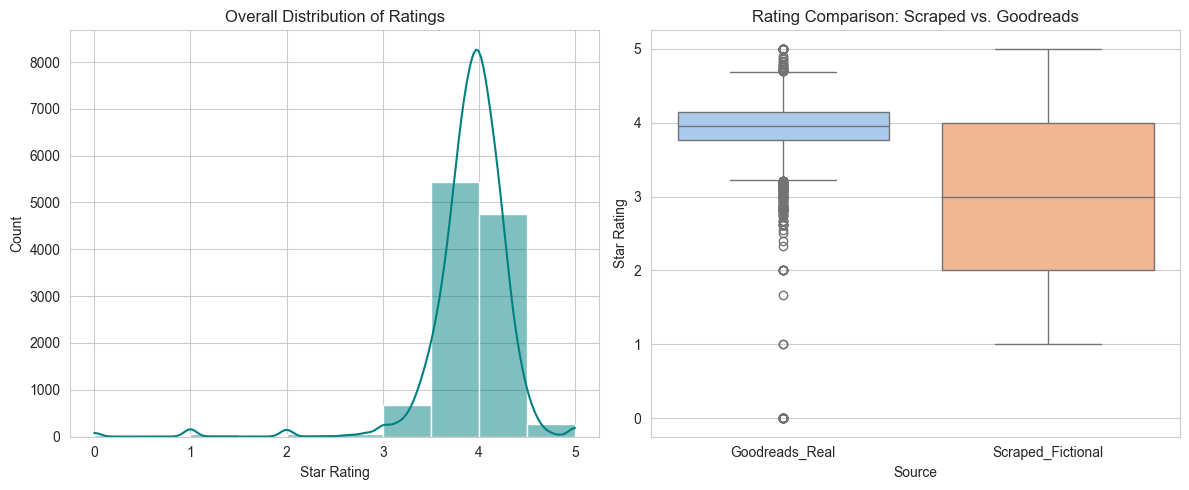

Average Rating by Source:
source
Goodreads_Real       3.934075
Scraped_Fictional    2.865000
Name: star_rating, dtype: float64


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned combined data
df_combined = pd.read_csv('cleaned_books_data.csv')

# Set plot style
sns.set_style("whitegrid")

# 1. Visualize Distribution of Ratings
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_combined['star_rating'], bins=10, kde=True, color='teal')
plt.title('Overall Distribution of Ratings')
plt.xlabel('Star Rating')

# 2. Compare Scraped vs Goodreads
plt.subplot(1, 2, 2)
sns.boxplot(data=df_combined, x='source', y='star_rating', palette='pastel')
plt.title('Rating Comparison: Scraped vs. Goodreads')
plt.xlabel('Source')
plt.ylabel('Star Rating')

plt.tight_layout()
plt.show()

# Print statistics
print("Average Rating by Source:")
print(df_combined.groupby('source')['star_rating'].mean())

### 2. Price & Category Analysis
Since the combined dataset lacks `category` information, we reload `scraped_books.csv` to analyze:
* Price vs. Rating relationships.
* Price distributions across different book categories.
* The most frequent categories.

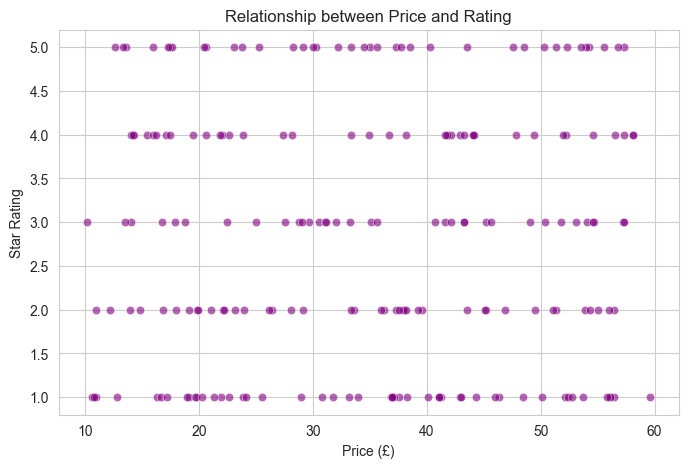

C:\Users\User\AppData\Local\Temp\ipykernel_9912\1777019496.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_cat, x='category', y='price', palette='coolwarm')


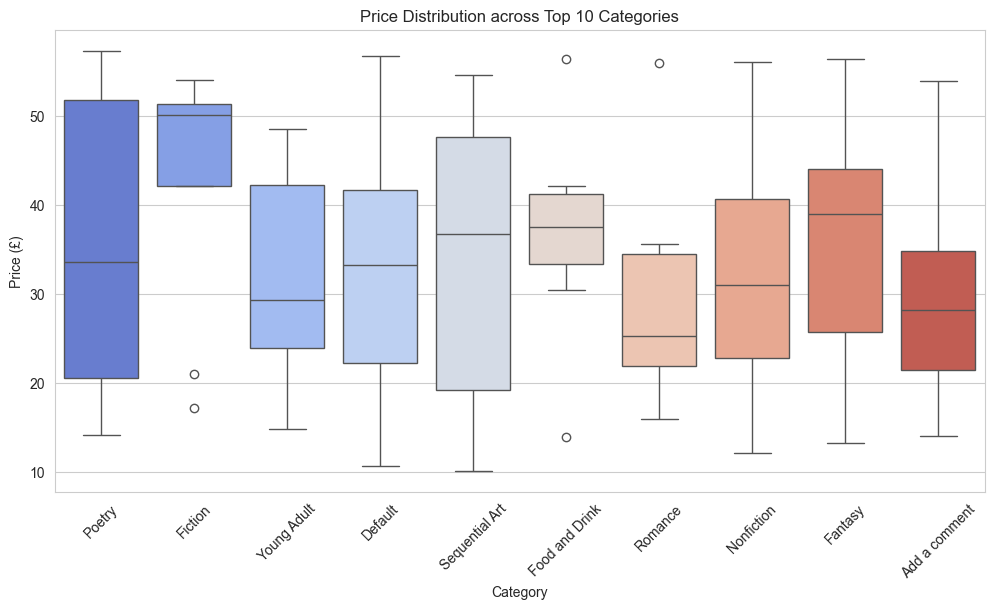


Average Rating per Top Category:
category
Fiction           3.888889
Young Adult       3.400000
Add a comment     3.000000
Romance           2.888889
Sequential Art    2.869565
Nonfiction        2.850000
Default           2.677419
Poetry            2.555556
Food and Drink    2.444444
Fantasy           2.400000
Name: star_rating, dtype: float64


In [10]:
# Reload Scraped Data (which has Category info)
df_scraped = pd.read_csv('scraped_books.csv')

# Ensure numeric types (Data Cleaning on the fly)
df_scraped['price'] = pd.to_numeric(df_scraped['price'], errors='coerce')
df_scraped['star_rating'] = pd.to_numeric(df_scraped['star_rating'], errors='coerce')

# 1. Price vs Rating Relationship
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_scraped, x='price', y='star_rating', alpha=0.6, color='purple')
plt.title('Relationship between Price and Rating')
plt.xlabel('Price (£)')
plt.ylabel('Star Rating')
plt.show()

# 2. Category Analysis
# Identify Top 10 Most Frequent Categories
top_categories = df_scraped['category'].value_counts().nlargest(10).index
df_top_cat = df_scraped[df_scraped['category'].isin(top_categories)]

# Plot Price Distribution across Top 10 Categories
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_cat, x='category', y='price', palette='coolwarm')
plt.title('Price Distribution across Top 10 Categories')
plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Price (£)')
plt.show()

# 3. Average Rating per Category (Top 10)
avg_rating_cat = df_top_cat.groupby('category')['star_rating'].mean().sort_values(ascending=False)
print("\nAverage Rating per Top Category:")
print(avg_rating_cat)

### 3. Text Analysis
We explore the book descriptions from the Scraped dataset.
* **Length vs. Rating:** Do longer descriptions get better ratings?
* **Word Frequency:** What words are common in High-Rated (4-5 stars) vs. Low-Rated (1-2 stars) books?

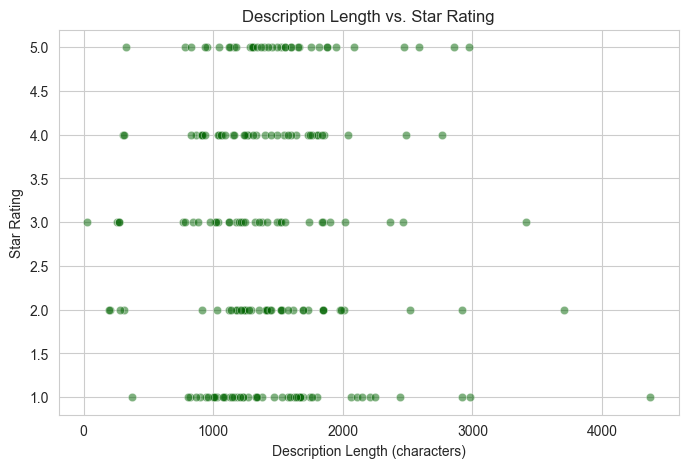

Top words in HIGH rated books (4-5 stars):
[('life', np.int64(74)), ('new', np.int64(70)), ('book', np.int64(56)), ('world', np.int64(53)), ('years', np.int64(40)), ('love', np.int64(40)), ('story', np.int64(37)), ('year', np.int64(32)), ('old', np.int64(29)), ('family', np.int64(29))]

Top words in LOW rated books (1-2 stars):
[('new', np.int64(110)), ('world', np.int64(72)), ('time', np.int64(68)), ('life', np.int64(61)), ('story', np.int64(43)), ('like', np.int64(36)), ('just', np.int64(36)), ('book', np.int64(35)), ('people', np.int64(35)), ('author', np.int64(34))]


In [11]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Handle missing descriptions
df_scraped['product_description'] = df_scraped['product_description'].fillna('')

# 1. Description Length vs Rating
df_scraped['desc_length'] = df_scraped['product_description'].apply(len)

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_scraped, x='desc_length', y='star_rating', alpha=0.5, color='darkgreen')
plt.title('Description Length vs. Star Rating')
plt.xlabel('Description Length (characters)')
plt.ylabel('Star Rating')
plt.show()

# 2. Common Words in High vs Low Rated Books
# Define High (>=4) and Low (<=2)
high_rated = df_scraped[df_scraped['star_rating'] >= 4]['product_description']
low_rated = df_scraped[df_scraped['star_rating'] <= 2]['product_description']

def get_top_words(text_series, n=10):
    if text_series.empty:
        return []
    # Use CountVectorizer to ignore stop words (like 'the', 'and')
    vec = CountVectorizer(stop_words='english')
    bag_of_words = vec.fit_transform(text_series)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

print("Top words in HIGH rated books (4-5 stars):")
print(get_top_words(high_rated))

print("\nTop words in LOW rated books (1-2 stars):")
print(get_top_words(low_rated))

## Task 2: Feature Engineering and Model Development

### 2.1 Feature Engineering (Text & Numerical)
We will generate new features from the `product_description` field:
1.  **Description Length:** The number of characters in the description.
2.  **Sentiment Polarity:** A score from -1 (Negative) to +1 (Positive) indicating the emotional tone of the description.

We also ensure `price` and `availability` are ready for the model.

In [12]:
import pandas as pd
from textblob import TextBlob

# 1. Load the Scraped Dataset (rich features)
df_model = pd.read_csv('scraped_books.csv')

# Handle missing values
df_model.dropna(subset=['product_description', 'star_rating', 'price'], inplace=True)

# 2. Feature: Description Length
df_model['desc_length'] = df_model['product_description'].apply(len)

# 3. Feature: Sentiment Analysis
# We define a simple function to get sentiment
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df_model['sentiment'] = df_model['product_description'].apply(get_sentiment)

# Check the new columns
print("New Features Added:")
display(df_model[['title', 'desc_length', 'sentiment', 'star_rating']].head())

New Features Added:


,title,desc_length,sentiment,star_rating
0,A Light in the Attic,1017,0.258352,3
1,Tipping the Velvet,1029,0.124838,1
2,Soumission,1093,0.000000,1
3,Sharp Objects,1635,-0.022523,4
4,Sapiens: A Brief History of Humankind,1945,0.001667,5


### 2.2 Target Variable Preparation (Classification)

[cite_start]We convert the `star_rating` into a binary target variable to build a Classification Model:
* **1 (High Success):** Rating >= 4
* **0 (Average/Low):** Rating < 4

This allows us to predict whether a book will be a "Hit" or not.

In [13]:
# Create Binary Target: 1 if rating >= 4, else 0
df_model['is_high_rated'] = df_model['star_rating'].apply(lambda x: 1 if x >= 4 else 0)

print("Target Distribution:")
print(df_model['is_high_rated'].value_counts())

Target Distribution:
is_high_rated
0    125
1     75
Name: count, dtype: int64


### 2.3 Data Preprocessing & Vectorization

We prepare the final dataset for training:
1.  [cite_start]**TF-IDF:** Convert text descriptions into numerical vectors.
2.  [cite_start]**One-Hot Encoding:** Convert categorical `category` data into numerical columns[cite: 57].
3.  **Combine:** Merge all features (Price, Availability, Sentiment, TF-IDF, Categories) into one feature set `X`.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# 1. Define Features (X) and Target (y)
# We drop text columns because we will transform them, and drop target columns to avoid cheating
X = df_model.drop(columns=['title', 'star_rating', 'is_high_rated', 'product_code'])
y = df_model['is_high_rated']

# 2. Setup Preprocessing Pipeline
# - TF-IDF for 'product_description'
# - OneHotEncoder for 'category'
# - Passthrough for numerical ('price', 'availability', 'desc_length', 'sentiment')

preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(max_features=500, stop_words='english'), 'product_description'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['category'])
    ],
    remainder='passthrough' # Keep price, availability, sentiment, etc.
)

# Apply transformations
X_processed = preprocessor.fit_transform(X)

print(f"Final Feature Matrix Shape: {X_processed.shape}")

Final Feature Matrix Shape: (200, 540)


### 2.4 Model Development and Evaluation

[cite_start]We split the data into **80% Training** and **20% Testing** sets.
[cite_start]We then train three different classification models and evaluate them using Accuracy and Classification Reports[cite: 83].

**Models:**
1.  Logistic Regression
2.  Random Forest Classifier
3.  Support Vector Machine (SVM)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# 1. Split Data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# 2. Initialize Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear')
}

# 3. Train and Evaluate
print("Model Performance Results:\n" + "="*30)

for name, model in models.items():
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    print(f"\nModel: {name}")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

Model Performance Results:


c:\Users\User\Documents\KSB Files\VScodeProjects\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Model: Logistic Regression
Accuracy: 0.6250
              precision    recall  f1-score   support

           0       0.67      0.89      0.76        27
           1       0.25      0.08      0.12        13

    accuracy                           0.62        40
   macro avg       0.46      0.48      0.44        40
weighted avg       0.53      0.62      0.55        40


Model: Random Forest
Accuracy: 0.6000
              precision    recall  f1-score   support

           0       0.65      0.89      0.75        27
           1       0.00      0.00      0.00        13

    accuracy                           0.60        40
   macro avg       0.32      0.44      0.38        40
weighted avg       0.44      0.60      0.51        40


Model: SVM
Accuracy: 0.6750
              precision    recall  f1-score   support

           0       0.72      0.85      0.78        27
           1       0.50      0.31      0.38        13

    accuracy                           0.68        40
   macro avg   